## Read time-dependent FISH transcriptome data from Aouefa

#### Read Excel sheet:

In [616]:
import pandas as pd
import csv
import cPickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import collections

%matplotlib inline

from pygenome import sg

In [617]:
phase_lengths = collections.OrderedDict([('early G1', 27.2), ('late G1', 33.7), ('S', 20.5), ('G2', 21.4), ('P/M', 9.8), 
                                         ('Ana', 10.4), ('T/C', 4.1)])
sum(phase_lengths.values())

127.10000000000001

In [618]:
phase_lengths.values()

[27.2, 33.7, 20.5, 21.4, 9.8, 10.4, 4.1]

Note that these are ordered as in the `OrderedDict`.

Aouefa's pivot table file containing distributions from the FISH experiments:

In [619]:
mrna_file = '../data/Sup_PivotTable_RNA_forPubli_AllGenes.xlsx'

In [620]:
df = {}
df_mult = {}
df_means = {}

In the following we make sure to only read the first table as the ones underneath contain data from osmostressed experiments.

In [621]:
df['YLR079W'] = pd.read_excel(mrna_file, sheetname='SIC1', skiprows=1, skipfooter=251, parse_cols='A, C:I')
df['YLR079W'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,22,24,22,24,6,1,0
1,1,35,53,41,45,22,1,0
2,2,48,74,54,36,20,10,0
3,3,30,52,22,19,10,6,0
4,4,10,19,9,10,6,4,0


In [622]:
df['YPL256C'] = pd.read_excel(mrna_file, sheetname='CLN2', skiprows=1, skipfooter=260, parse_cols='A, C:I')
df['YPL256C'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,123,15,38,105,55,35,11
1,1,27,8,22,37,12,23,6
2,2,11,11,9,20,6,3,3
3,3,12,7,12,4,1,2,1
4,4,10,2,2,1,0,2,0


In [623]:
df['YPR120C'] = pd.read_excel(mrna_file, sheetname='CLB5', skiprows=1, skipfooter=89, parse_cols='A, C:I')
df['YPR120C'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,69,35,55,94,43,45,6
1,1,46,47,47,31,19,26,10
2,2,27,27,27,12,8,5,1
3,3,10,25,22,5,0,3,2
4,4,4,32,12,3,0,4,3


#### Calculate means per cell cycle phase:

In [624]:
df_mult['YLR079W'] = df['YLR079W'].mul(df['YLR079W']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['YLR079W'] = df_mult['YLR079W'].sum(axis=0) / df['YLR079W'].sum(axis=0).drop('# RNA/cell')
df_means['YLR079W']

early G1     4.084577
late G1      3.449275
S            2.343195
G2           2.055944
P/M          2.101449
Ana         14.231884
T/C         24.933333
dtype: float64

In [625]:
df_mult['YPL256C'] = df['YPL256C'].mul(df['YPL256C']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['YPL256C'] = df_mult['YPL256C'].sum(axis=0) / df['YPL256C'].sum(axis=0).drop('# RNA/cell')
df_means['YPL256C']

early G1     3.254237
late G1     18.021277
S            5.644628
G2           0.666667
P/M          0.364865
Ana          1.119403
T/C          2.592593
dtype: float64

In [626]:
df_mult['YPR120C'] = df['YPR120C'].mul(df['YPR120C']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['YPR120C'] = df_mult['YPR120C'].sum(axis=0) / df['YPR120C'].sum(axis=0).drop('# RNA/cell')
df_means['YPR120C']

early G1    1.321429
late G1     3.783784
S           1.826816
G2          0.565517
P/M         0.619718
Ana         0.977273
T/C         2.793103
dtype: float64

We know have absolute abundance values of three transcript types during the whole cell cycle. The next step will be to combine this information with the relative abundance data from Lotte's RNAseq experiments.

## Map to RNAseq data from Lotte

#### Discover corresponding genes in Lotte transcriptome:

YLR079W is Sic1

YPL256C is Cln2

YPR120C is Clb5

Read file:

In [627]:
filename = "../data/nostress_WT_R1.csv"
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))

transcripts = pd.DataFrame()

with open(filename, mode='r') as infile:
    reader = csv.reader(infile, delimiter=',')
    times = [float(val) for val in reader.next()[2:]]
    print times
    ntimes = len(times)
    for rows in reader:
        try:
            # convert to systematic names
            colname = rows[0] if rows[0] in orf_genomic_dict else sg.systematic_name(rows[0])
            transcript_values = pd.Series(data=[float(rows[i]) for i in range(2, ntimes + 2)])  
            # the time point -1 is not needed
            transcripts[colname] = transcript_values
        except:
            pass

[-0.1, 0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0]


In [628]:
transcripts.index = times
print len(transcripts.columns)

5795


In [629]:
transcripts

,YAL001C,YAL002W,YAL003W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,...,YHR214C-E,YIL156W-B,YIL134C-A,YIL105W-A,YIL102C-A,YIL046W-A,YIL014C-A,YIL002W-A,YIR018C-A,YIR021W-A
-0.1,4,5,227,386.259074,18,9,7,3,7,228,...,0,12,1,8,0,3,21.5,91,6.0,0
0.0,3,10,301,447.242105,14,14,15,3,3,380,...,0,23,0,20,0,0,12.5,99,5.5,0
5.0,12,1,222,376.813333,14,12,7,1,7,320,...,0,26,1,7,2,1,14.0,100,8.0,3
10.0,5,4,180,233.285132,23,14,7,1,5,245,...,0,15,0,6,0,0,6.0,76,2.5,0
15.0,5,5,256,234.858509,25,13,10,3,8,303,...,0,31,0,5,2,0,13.0,95,2.5,3
20.0,7,5,291,283.728916,27,10,12,2,8,312,...,0,25,0,6,4,0,12.0,113,2.0,6
25.0,5,4,224,186.376147,17,10,14,1,2,181,...,0,15,0,12,0,3,8.0,67,5.0,1
30.0,6,7,323,299.370611,27,8,15,4,5,295,...,0,18,1,18,2,1,13.5,108,3.5,1
35.0,3,9,345,326.945819,26,8,12,2,8,298,...,0,29,0,31,3,0,13.0,96,3.0,5
40.0,4,3,131,196.814969,10,3,13,2,2,159,...,0,11,1,21,0,1,14.0,51,1.0,1


Create "normalized" transcriptome (containing percentages at each point in time):

In [630]:
transcripts_norm = (transcripts.T / transcripts.sum(axis=1)).T

Plot cell cycle genes in Lotte data:

In [631]:
sic1 = transcripts_norm['YLR079W']
cln2 = transcripts_norm['YPL256C']
clb5 = transcripts_norm['YPR120C']

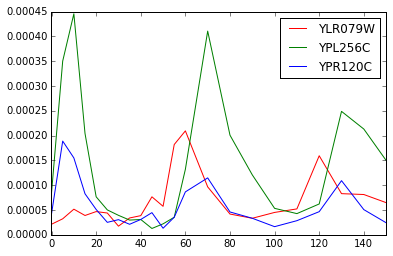

In [632]:
sic1.plot(legend=True, color='r')
cln2.plot(legend=True, color='g')
clb5.plot(legend=True, color='b')

## Obtain absolute time-resolved transcriptome

According to Lotte, the  G1 phase of the first cell cycle is only represented by the data point at t = 0.1 because cells are released from the G1 phase.

According to Max, Marcus ad Lotte, the  G1 phase of the second cell cycle is also shortened because cells were kept in arrest and were allowed to build capacity to shorten the G1 phase.

Plot Aouefa's data for comparison:

In [633]:
df_means['YLR079W'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.
df_means['YPL256C'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.
df_means['YPR120C'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.

The subtracted array centers the phases at the middle of the interval.

In [634]:
means = pd.DataFrame(df_means)

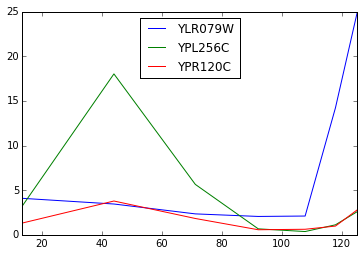

In [635]:
means.plot()

The data look qualitatively similar but with a longer G1 phase.

Next steps: 

* assume that the very first data point of RNAseq data represents the G1 phase
* find boundaries of other phases
* calculate averages of RNAseq data per cell cycle phase
* calculate multipliers per cell cycle phase for each cell cycle gene
* find "best" multiplier (e.g. average of the three multipliers)
* use multipliers to calculate absolute transcriptome

#### Find total length of RNAseq cell cycle:

In [636]:
cln2.sort_values(axis=0, ascending=False, inplace=False)

 10.0     0.000446
 70.0     0.000411
 5.0      0.000350
 130.0    0.000249
 140.0    0.000213
 15.0     0.000204
 80.0     0.000201
 150.0    0.000150
 60.0     0.000132
 90.0     0.000121
 0.0      0.000085
 20.0     0.000077
 120.0    0.000062
 100.0    0.000053
 25.0     0.000050
-0.1      0.000044
 110.0    0.000043
 30.0     0.000039
 55.0     0.000035
 40.0     0.000031
 35.0     0.000030
 50.0     0.000022
 45.0     0.000013
Name: YPL256C, dtype: float64

We see that the sum of all phases except the absent G1 phase is 60 mins (maxima at 10, 70, 130 mins).

Corresponding duration in Aouefa's data (sum of phase lengths except G1):

In [637]:
sum(phase_lengths.values()[2:])

66.2

To match the RNAseq cell cycle we will scale Aouefa's values by 60.0/66.2:

In [638]:
rnaseq_phase_lengths = collections.OrderedDict([('early G1', round(27.2 * 60.0/66.2, 1)), 
                                                ('late G1', round(33.7 * 60.0/66.2, 1)), 
                                                ('S', round(20.5 * 60.0/66.2, 1)), 
                                                ('G2', round(21.4 * 60.0/66.2, 1)), 
                                                ('P/M', round(9.8 * 60.0/66.2, 1)), 
                                                ('Ana', round(10.4 * 60.0/66.2, 1)), 
                                                ('T/C', round(4.1 * 60.0/66.2,1))])

In [639]:
rnaseq_phase_lengths

OrderedDict([('early G1', 24.7), ('late G1', 30.5), ('S', 18.6), ('G2', 19.4), ('P/M', 8.9), ('Ana', 9.4), ('T/C', 3.7)])

In [640]:
round(sum(rnaseq_phase_lengths.values()), 1)

115.2

Next we calculate the averages of the cell cycle genes in RNAseq per cell cycle phase. 

* The measurement at -0.1 is used as a proxy for the entire G1 phase
* Only the first cell cycle is considered.
* To be able to map the times accurately, we first "blow up" the RNAseq data in units of 0.1 min

In [641]:
rnaseq_means = {}
for gene in ['YLR079W', 'YPL256C', 'YPR120C']:
    rnaseq_means[gene] = {'early G1': transcripts_norm[gene][-0.1], 'late G1': transcripts_norm[gene][-0.1]}

In [642]:
rnaseq_means

{'YLR079W': {'early G1': 3.3234762501156854e-05,
  'late G1': 3.3234762501156854e-05},
 'YPL256C': {'early G1': 4.4313016668209145e-05,
  'late G1': 4.4313016668209145e-05},
 'YPR120C': {'early G1': 4.9852143751735284e-05,
  'late G1': 4.9852143751735284e-05}}

The values for the later phases are defined in the following.

First we shift the times in Lotte's transcriptome by the scaled value of Aouefa's G1 phase:

The index has to begin at the beginning of S phase (24.7 + 30.5) and end after T/C phase (115.2).

In [643]:
transcripts_norm.index += (rnaseq_phase_lengths['early G1'] + rnaseq_phase_lengths['late G1'])

In [644]:
transcripts_norm = transcripts_norm.drop(transcripts_norm.head(1).index)
transcripts_norm

,YAL001C,YAL002W,YAL003W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,...,YHR214C-E,YIL156W-B,YIL134C-A,YIL105W-A,YIL102C-A,YIL046W-A,YIL014C-A,YIL002W-A,YIR018C-A,YIR021W-A
55.2,0.000013,0.000043,0.001283,0.001906,0.000060,0.000060,0.000064,0.000013,0.000013,0.001620,...,0,0.000098,0.000000,0.000085,0.000000,0.000000,0.000053,0.000422,0.000023,0.000000
60.2,0.000055,0.000005,0.001023,0.001737,0.000065,0.000055,0.000032,0.000005,0.000032,0.001475,...,0,0.000120,0.000005,0.000032,0.000009,0.000005,0.000065,0.000461,0.000037,0.000014
65.2,0.000032,0.000026,0.001162,0.001507,0.000149,0.000090,0.000045,0.000006,0.000032,0.001582,...,0,0.000097,0.000000,0.000039,0.000000,0.000000,0.000039,0.000491,0.000016,0.000000
70.2,0.000024,0.000024,0.001246,0.001143,0.000122,0.000063,0.000049,0.000015,0.000039,0.001475,...,0,0.000151,0.000000,0.000024,0.000010,0.000000,0.000063,0.000462,0.000012,0.000015
75.2,0.000030,0.000021,0.001238,0.001207,0.000115,0.000043,0.000051,0.000009,0.000034,0.001328,...,0,0.000106,0.000000,0.000026,0.000017,0.000000,0.000051,0.000481,0.000009,0.000026
80.2,0.000031,0.000025,0.001406,0.001169,0.000107,0.000063,0.000088,0.000006,0.000013,0.001136,...,0,0.000094,0.000000,0.000075,0.000000,0.000019,0.000050,0.000420,0.000031,0.000006
85.2,0.000026,0.000031,0.001409,0.001306,0.000118,0.000035,0.000065,0.000017,0.000022,0.001287,...,0,0.000079,0.000004,0.000079,0.000009,0.000004,0.000059,0.000471,0.000015,0.000004
90.2,0.000013,0.000038,0.001463,0.001387,0.000110,0.000034,0.000051,0.000008,0.000034,0.001264,...,0,0.000123,0.000000,0.000131,0.000013,0.000000,0.000055,0.000407,0.000013,0.000021
95.2,0.000031,0.000023,0.001012,0.001520,0.000077,0.000023,0.000100,0.000015,0.000015,0.001228,...,0,0.000085,0.000008,0.000162,0.000000,0.000008,0.000108,0.000394,0.000008,0.000008
100.2,0.000026,0.000026,0.001730,0.001256,0.000051,0.000032,0.000051,0.000000,0.000032,0.001532,...,0,0.000102,0.000000,0.000089,0.000006,0.000006,0.000067,0.000357,0.000022,0.000006


In [645]:
detail_df = pd.DataFrame(np.arange(55.2, round(sum(rnaseq_phase_lengths.values())+0.1, 1), 0.1))
detail_df = detail_df.set_index(np.arange(55.2, round(sum(rnaseq_phase_lengths.values())+0.1, 1), 0.1))
detail_df.drop(0, axis=1, inplace=True)

In [646]:
for gene in ['YLR079W', 'YPL256C', 'YPR120C']:
    detail_df = pd.merge(detail_df, pd.DataFrame(transcripts_norm[gene]), how='outer', left_index=True, 
                         right_index=True)
detail_df = detail_df[:115.3]
detail_df = detail_df.drop(detail_df.tail(1).index)

In [647]:
detail_df

,YLR079W,YPL256C,YPR120C
55.2,0.000021,0.000085,0.000043
55.3,NaN,NaN,NaN
55.4,NaN,NaN,NaN
55.5,NaN,NaN,NaN
55.6,NaN,NaN,NaN
55.7,NaN,NaN,NaN
55.8,NaN,NaN,NaN
55.9,NaN,NaN,NaN
56.0,NaN,NaN,NaN
56.1,NaN,NaN,NaN


In [648]:
detail_df[detail_df['YLR079W']>0]

,YLR079W,YPL256C,YPR120C
55.2,0.000021,0.000085,0.000043
60.2,0.000032,0.000350,0.000189
65.2,0.000052,0.000446,0.000155
70.2,0.000039,0.000204,0.000083
75.2,0.000047,0.000077,0.000051
80.2,0.000044,0.000050,0.000025
85.2,0.000017,0.000039,0.000031
90.2,0.000034,0.000030,0.000021
95.2,0.000039,0.000031,0.000031
100.2,0.000077,0.000013,0.000045


In [652]:
detail_interpolated_df = detail_df.interpolate(method='index', axis=0)

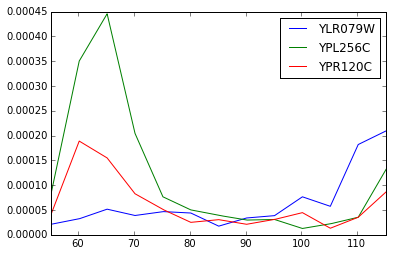

In [653]:
detail_interpolated_df.plot()

In [654]:
detail_interpolated_df

,YLR079W,YPL256C,YPR120C
55.2,0.000021,0.000085,0.000043
55.3,0.000022,0.000091,0.000046
55.4,0.000022,0.000096,0.000048
55.5,0.000022,0.000101,0.000051
55.6,0.000022,0.000106,0.000054
55.7,0.000022,0.000112,0.000057
55.8,0.000023,0.000117,0.000060
55.9,0.000023,0.000122,0.000063
56.0,0.000023,0.000128,0.000066
56.1,0.000023,0.000133,0.000069
